In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import duckdb
import math

conn = duckdb.connect(database=':memory:')

In [7]:
# https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
fraud_df = pd.read_csv('creditcard.csv',sep=',')

conn.execute("CREATE TABLE fraud_data AS SELECT * FROM fraud_df")

In [8]:
fraud_df[['Amount']].head()

,Amount
0,149.62
1,2.69
2,378.66
3,123.50
4,69.99


In [9]:
df = fraud_df
# print(df.info)
print(df.columns)
print(df.dtypes)
# print(df.describe())
print('Complete size of data set:')
print(df.shape[0])
# checking for missing values
print('Num values missing:')
print(df.isna().sum())

N_norm = df[df['Class'] == 0].shape[0]
N_fraud = df[df['Class'] == 1].shape[0]
print('Number of non-fraudulent transactions:',
      N_norm)
print('Number of fraudulent transactions:',
      N_fraud)
print('Percent of fraudulent transactions:',
      100*N_fraud/df.shape[0])

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object
Complete size of data set:
284807
Num values missing:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V

So there are no missing values in the data set.

There is a very low percentage of fraudulent transactions; 0.17%.

   Class  N_cases   N_tot  frac_cases
0      0   284315  284807    0.998273
1      1      492  284807    0.001727


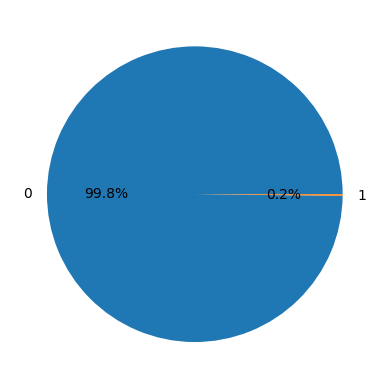

In [10]:
fraud_br = conn.execute(f"""
    SELECT *, N_cases / N_tot AS frac_cases
    FROM (
        SELECT Class, COUNT(*) AS N_cases
        FROM fraud_data
        WHERE Class is not null
        GROUP BY Class
    )
    INNER JOIN (
        SELECT COUNT(*) AS N_tot FROM fraud_data WHERE Class is not null
    )
    ON true""").df()
print(fraud_br)


# Create the pie chart with percentages
plt.pie(fraud_br['frac_cases'], labels=fraud_br['Class'], autopct='%.1f%%', startangle=0)
#plt.show()
plt.savefig('breakdown_plots/fraud_pie.png')
# plt.clf()

In [16]:
import os
os.getcwd()

'/Users/Ben/PycharmProjects/Fraud_Detection'

In [25]:

df_orig = fraud_df
columns = list(df_orig.columns)
columns.remove('Class')
# bins = np.linspace(min(df_orig[col]), max(df_orig[col]), 50)
for col in columns:
      minimum = int(math.floor(min(df_orig[col])))
      if col == 'Amount':
            maximum = int(math.ceil(df_orig[col].mean() + 10*df_orig[col].std()))
      else:
            maximum = int(df_orig[col].max())
      bins = np.linspace(minimum, maximum, 50)

      plt.hist(df_orig[col], bins, alpha=0.5, label='0', density=True)
      plt.xlabel(col)
      plt.ylabel('Probability Density')
      plt.title(f'{col} Histogram')
      plt.savefig(f'breakdown_plots/Histograms/{col}_hist.png')
      plt.clf()

<Figure size 640x480 with 0 Axes>

In [27]:
from sklearn.model_selection import train_test_split
df = fraud_df
# Assuming 'df' is your DataFrame and 'target' is the target column
# Separate majority and minority classes
df_majority = df[df.Class == 0] # Assuming 0 is the majority class
df_minority = df[df.Class == 1] # Assuming 1 is the minority class

from sklearn.utils import resample

# Downsample majority class
df_majority_downsampled = resample(df_majority,
                                   replace=False,    # sample without replacement
                                   n_samples=len(df_minority), # to match minority class size
                                   random_state=999)  # for reproducibility

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_majority_downsampled, df_minority])

In [28]:
df_balanced.shape

(984, 31)

In [29]:

df_orig = df_balanced
columns = list(df_orig.columns)
columns.remove('Class')
# bins = np.linspace(min(df_orig[col]), max(df_orig[col]), 50)
for col in columns:
      minimum = int(math.floor(min(df_orig[col])))
      if col == 'Amount':
            maximum = int(math.ceil(df_orig[col].mean() + 10*df_orig[col].std()))
      else:
            maximum = int(df_orig[col].max())
      bins = np.linspace(minimum, maximum, 50)

      plt.hist(df_orig[col], bins, alpha=0.5, label='0', density=True)
      plt.xlabel(col)
      plt.ylabel('Probability Density')
      plt.title(f'{col} Histogram')
      plt.savefig(f'breakdown_plots/Histograms_Downsample/{col}_hist.png')
      plt.clf()

<Figure size 640x480 with 0 Axes>

In [60]:
fraud_df.shape

(284807, 31)

In [30]:

df_orig = df_balanced
columns = list(df_orig.columns)
columns.remove('Class')
breakdown_var = 'Class'
# bins = np.linspace(min(df_orig[col]), max(df_orig[col]), 50)
for col in columns:
      minimum = int(math.floor(min(df_orig[col])))
      if col == 'Amount':
            maximum = int(math.ceil(df_orig[col].mean() + 10*df_orig[col].std()))
      else:
            maximum = int(df_orig[col].max())
      bins = np.linspace(minimum, maximum, 50)
      var_list = list(np.unique(df_orig[breakdown_var]))
      dict_comp = {}
      for var in var_list:
          dict_comp[var] = df_orig[df_orig[breakdown_var] == var]
      for var in var_list:
          plt.hist(dict_comp[var][col], bins, alpha=0.5, label=var, density=True)
      plt.legend(loc='upper right')

      # plt.savefig('histogram_plots/'+col+'_histogram.png')
      # plt.clf()
      # plt.hist(df_orig[col], bins, alpha=0.5, label='0', density=True)
      plt.xlabel(col)
      plt.ylabel('Probability Density')
      plt.title(f'{col} Histogram with Downsampled Data')
      plt.tight_layout()
      # plt.show()
      plt.savefig(f'breakdown_plots/Histograms_Downsample_Split/{col}_hist.png')
      plt.clf()

<Figure size 640x480 with 0 Axes>

In [43]:
from sklearn.model_selection import train_test_split

df_orig_bal = df_balanced
columns = list(df_orig_bal.columns)
columns.remove('Class')
# Separate features (X) and target variable (y)
X = df_orig_bal[columns]
y = df_orig_bal['Class']

# 2. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=999, stratify=y
)

In [33]:
X_train.shape

(885, 30)

Ranked Feature Importances:
   Feature  Importance
14     V14    0.192361
10     V10    0.131596
4       V4    0.095359
11     V11    0.067816
12     V12    0.067116
17     V17    0.056858
16     V16    0.050040
3       V3    0.049879
9       V9    0.038066
2       V2    0.031352
7       V7    0.028320
27     V27    0.018872
18     V18    0.017905
21     V21    0.016670
8       V8    0.013683
6       V6    0.013631
19     V19    0.013144
29  Amount    0.011860
20     V20    0.010855
28     V28    0.009614
23     V23    0.007850
5       V5    0.007610
15     V15    0.007202
1       V1    0.006601
26     V26    0.006537
24     V24    0.006347
22     V22    0.006251
13     V13    0.006013
0     Time    0.005567
25     V25    0.005023


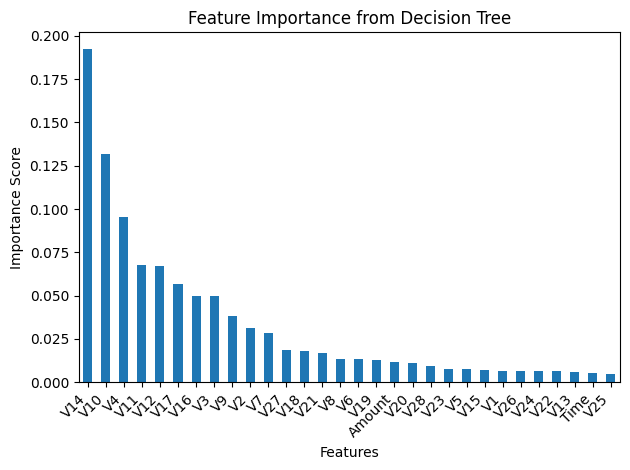

In [44]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=999)
model.fit(X_train, y_train)

feature_names = columns
# 4. Access feature importances
importances = model.feature_importances_
# 5. Create a DataFrame for better visualization and sorting
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# 6. Sort features by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 7. Print or visualize the ranked features
print("Ranked Feature Importances:")
print(feature_importance_df)

feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)
feature_importances.plot.bar()
plt.title('Feature Importance from Decision Tree')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# plt.savefig(f'feature_scores.png')
plt.show()


Now based on looking at this in combination with the histograms I created, the last variable that seems to have differentiating behaviour on the Class variable is V19.  As such I will remove all the variables Amount and onwards from our list of variables.

This can be done differently, and more scientifically.  For example one can train the model for each separate list of variables including one more at a time.  Something like Forward or Backward Stepwise Selection methods.  And one doesn't have to use this metric either.

To save myself some time though, I'm just trying to get a half decent result relatively quickly and this is what I'm choosing to do.

In [45]:
final_feature_list = list(feature_importance_df[feature_importance_df.Importance > 0.0119].Feature)
X_train2 = X_train[final_feature_list]
X_test2 = X_test[final_feature_list]

Perform Random Forest

In [54]:
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.datasets import make_classification
import scipy.stats as stats


random_grid = {'bootstrap': [True],
               'max_depth': [3, 5, 10, None],
               'max_features': ['sqrt'],
               'min_samples_leaf': [2, 4, 6, 8],
               'min_samples_split': [2, 3, 4],
               'n_estimators': [100, 150, 200]}


rf = RandomForestClassifier()

rf_random = RandomizedSearchCV(
    estimator=rf,
    param_distributions=random_grid,
    n_iter=100,  # Number of random combinations to try
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=999),
    scoring='f1',
    random_state=999,
    n_jobs=-1,
    verbose=0
)
# Fit the random search model
rf_random.fit(X_train2, y_train)

print(rf_random.best_params_)
print(rf_random.best_score_)
print(rf_random.best_estimator_)

# Evaluate the best model on the test set
best_model_rf = rf_random.best_estimator_
test_accuracy_rf = best_model_rf.score(X_test2, y_test)
print("Test set f1-score with best model:", test_accuracy_rf)

{'n_estimators': 150, 'min_samples_split': 4, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
0.9378646116867053
RandomForestClassifier(min_samples_leaf=4, min_samples_split=4,
                       n_estimators=150)
Test set f1-score with best model: 0.9494949494949495


Random Forest - best choice of hyperparameters: {'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None, 'bootstrap': True}
94.23% CV (5-fold) accuracy on a downsampled data set that is split 50-50, that's pretty darned good.

F1-Score CV: 0.9378

On the test set this performs close to 95% accurate, but this is close to the CV average of 93.93%.

Perform XGBoost.

In [55]:
# begin by standardizing variables
mean_vals = X_train2.mean()
std_vals = X_train2.std()
X_train_std = (X_train2 - mean_vals)/std_vals
X_test_std = (X_test2 - mean_vals)/std_vals
# Define the XGBoost model
xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Define the hyperparameter distributions for RandomizedSearchCV
# Using scipy.stats distributions for continuous parameters
param_dist = {
    'n_estimators': stats.randint(100, 500),  # Number of boosting rounds
    'learning_rate': stats.uniform(0.01, 0.2),  # Step size shrinkage
    'max_depth': stats.randint(3, 10),  # Maximum depth of a tree
    'subsample': stats.uniform(0.6, 0.4),  # Subsample ratio of the training instance
    'colsample_bytree': stats.uniform(0.6, 0.4),  # Subsample ratio of columns when constructing each tree
    'gamma': stats.uniform(0, 0.2),  # Minimum loss reduction required to make a further partition
    'reg_alpha': stats.uniform(0, 0.1),  # L1 regularization term on weights
    'reg_lambda': stats.uniform(0, 1)  # L2 regularization term on weights
}

random_search_xgb = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of random combinations to try
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=999),
    scoring='f1',
    # scoring='average_precision',
    random_state=999,
    n_jobs=-1,
    verbose=0
)

random_search_xgb.fit(X_train_std, y_train)

print("\nBest set of hyperparameters:", random_search_xgb.best_params_)
print("Best cross-validation score:", random_search_xgb.best_score_)
print("Best cross-validation estimator:", random_search_xgb.best_estimator_)

# Evaluate the best model on the test set
best_model_xgb = random_search_xgb.best_estimator_

from sklearn.metrics import average_precision_score
# auprc = average_precision_score(y_test, best_model_xgb.predict(X_test_std.to_numpy()))
test_accuracy_xgb = best_model_xgb.score(X_test_std, y_test)
print("Test set f1-score with best model:", test_accuracy_xgb)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,  best_model_xgb.predict(X_test_std.to_numpy()))
print(cm)



Best set of hyperparameters: {'colsample_bytree': 0.65234695245181, 'gamma': 0.16350242907332466, 'learning_rate': 0.16604690153357163, 'max_depth': 5, 'n_estimators': 120, 'reg_alpha': 0.02104653543525822, 'reg_lambda': 0.9347011734414674, 'subsample': 0.6494923628434196}
Best cross-validation score: 0.9424763585770009
Best cross-validation estimator: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.65234695245181, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=0.16350242907332466, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.16604690153357163,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
            

XGBoost seems to perform a little better than random forest with approximately 94.35% CV (5-fold) accuracy.

F1-Score CV: 0.9424

The best AUPRC score averaged over 5-fold CV is: 0.9860

On the test set the AUPRC is 0.9285

Perform Logistic Regression

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from scipy.stats import loguniform

# begin by standardizing variables
mean_vals = X_train2.mean()
std_vals = X_train2.std()
X_train_std = (X_train2 - mean_vals)/std_vals
X_test_std = (X_test2 - mean_vals)/std_vals
# Define the log reg model
logistic_regression = LogisticRegression(solver='liblinear', random_state=999)

# Define the hyperparameter distributions for RandomizedSearchCV
# Using scipy.stats distributions for continuous parameters
param_distributions = {
    'C': loguniform(1e-5, 100),  # Regularization strength
    'penalty': ['l1', 'l2']      # Regularization type
}

random_search_log = RandomizedSearchCV(
    estimator=logistic_regression,
    param_distributions=param_distributions,
    n_iter=50,  # Number of random combinations to try
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=999),
    # scoring='accuracy',
    scoring='f1',
    random_state=999,
    n_jobs=-1,
    verbose=0
)

random_search_log.fit(X_train_std, y_train)

print("\nBest set of hyperparameters:", random_search_log.best_params_)
print("Best cross-validation score:", random_search_log.best_score_)
print("Best cross-validation estimator:", random_search_log.best_estimator_)

# Evaluate the best model on the test set
best_model_log = random_search_log.best_estimator_
test_accuracy_log = best_model_log.score(X_test_std, y_test)
print("Test set f1 score with best model:", test_accuracy_log)



Best set of hyperparameters: {'C': 1.041022459301857, 'penalty': 'l2'}
Best cross-validation score: 0.9425875401915034
Best cross-validation estimator: LogisticRegression(C=1.041022459301857, random_state=999, solver='liblinear')
Test set f1 score with best model: 0.9595959595959596


Logistic regression has an excellent CV (5-fold) accuracy score of 94.46327%.

F1-Score CV: 0.9425

The best AUPRC score averaged over 5-fold CV is: 0.9854.

On test data performs with AUPRC of 0.9393.

Perform Naive Bayes

In [57]:
from sklearn.naive_bayes import BernoulliNB

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from scipy.stats import loguniform

# begin by standardizing variables
mean_vals = X_train2.mean()
std_vals = X_train2.std()
X_train_std = (X_train2 - mean_vals)/std_vals
X_test_std = (X_test2 - mean_vals)/std_vals
# Define the Bernoulli Naive Bayes (good for binary classification) model
bnb = BernoulliNB()

# Define the hyperparameter search space for alpha (Laplace smoothing parameter)
# A log-uniform distribution is often suitable for 'alpha'
param_distributions = {
    'alpha': loguniform.rvs(1e-3, 1e2, size=200) # Example range for alpha
}

random_search_nb = RandomizedSearchCV(
    estimator=bnb,
    param_distributions=param_distributions,
    n_iter=50,  # Number of random combinations to try
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=999),
    # scoring='accuracy',
    scoring='f1',
    random_state=999,
    n_jobs=-1,
    verbose=0
)

random_search_nb.fit(X_train_std, y_train)

print("\nBest set of hyperparameters:", random_search_nb.best_params_)
print("Best cross-validation score:", random_search_nb.best_score_)
print("Best cross-validation estimator:", random_search_nb.best_estimator_)

# Evaluate the best model on the test set
best_model_nb = random_search_nb.best_estimator_
test_accuracy_nb = best_model_nb.score(X_test_std, y_test)
print("Test set f1 score with best model:", test_accuracy_nb)



Best set of hyperparameters: {'alpha': 0.10381610957451365}
Best cross-validation score: 0.9035800661022005
Best cross-validation estimator: BernoulliNB(alpha=0.10381610957451365)
Test set f1 score with best model: 0.9090909090909091


Naive Bayes doesn't perform as well as Random forest, XGBoost or Logistic regression with about 91.2% accuracy.

F1-Score CV: 0.9036

Perform Support Vector Classification

In [58]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from scipy.stats import loguniform

# begin by standardizing variables
mean_vals = X_train2.mean()
std_vals = X_train2.std()
X_train_std = (X_train2 - mean_vals)/std_vals
X_test_std = (X_test2 - mean_vals)/std_vals
# Define the Support Vector Classification model
svc = SVC(random_state=999)

param_distributions = {
    'C': loguniform(1e-3, 1e3),  # C can range from 0.001 to 1000 on a log scale
    'gamma': loguniform(1e-4, 1e-1), # gamma can range from 0.0001 to 0.1 on a log scale
    'kernel': ['rbf', 'linear'] # Example: trying different kernels
}

random_search_svc = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_distributions,
    n_iter=50,  # Number of random combinations to try
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=999),
    scoring='f1',
    # scoring='average_precision',
    random_state=999,
    n_jobs=-1,
    verbose=0
)

random_search_svc.fit(X_train_std, y_train)

print("\nBest set of hyperparameters:", random_search_svc.best_params_)
print("Best cross-validation score:", random_search_svc.best_score_)
print("Best cross-validation estimator:", random_search_svc.best_estimator_)

# Evaluate the best model on the test set
best_model_svc = random_search_svc.best_estimator_
test_accuracy_svc = best_model_svc.score(X_test_std, y_test)
print("Test set f1 score with best model:", test_accuracy_svc)



Best set of hyperparameters: {'C': 1.2249995127472268, 'gamma': 0.0037039528862068648, 'kernel': 'linear'}
Best cross-validation score: 0.9393227455165579
Best cross-validation estimator: SVC(C=1.2249995127472268, gamma=0.0037039528862068648, kernel='linear',
    random_state=999)
Test set f1 score with best model: 0.9595959595959596


Support Vector Classification performs quite well too, with over 94% accuracy.

F1-Score CV: 0.9393

Average AUPRC of best model is 0.9858.  On the test set it's 0.9494.

The best performing models are Random Forest, XGBoost, Logistic Regression and Support Vector Classification.

I want to see how hard voting works here when used on XGBoost, Logistic Regression and Support Vector Classification.  I've removed Random Forest because it inherently will behave similarly to XGBoost and we want predictors with differing methodologies.

In [52]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, f1_score
model1 = best_model_xgb
model2 = best_model_log
model3 = best_model_svc
# SVC?
# Create a VotingClassifier
# Hard Voting

ensemble_model = VotingClassifier(
    estimators=[('xgb', model1), ('log', model2), ('SVC', model3)],
    voting='hard'  # 'hard' for majority voting (class with most votes)
)


scores_hard = cross_val_score(ensemble_model, X_train_std, y_train,
                              cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=999),
                              scoring='f1'
                              # scoring='roc_auc_ovr'
                              )
print(f"Hard Voting Classifier Accuracy (Cross-Validation): "
      f"{np.mean(scores_hard):.4f} +/- {np.std(scores_hard):.4f}")


ensemble_model.fit(X_train_std, y_train)

y_pred_ensemble = ensemble_model.predict(X_test_std)
# Evaluate the ensemble model
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
print(f"Ensemble Model Accuracy on test set (Hard Voting): {ensemble_accuracy:.4f}")
ensemble_f1_score = f1_score(y_test, y_pred_ensemble)
print(f"Ensemble Model F1-Score on test set (Hard Voting): {ensemble_f1_score:.4f}")


Hard Voting Classifier Accuracy (Cross-Validation): 0.9427 +/- 0.0098
Ensemble Model Accuracy on test set (Hard Voting): 0.9596
Ensemble Model F1-Score on test set (Hard Voting): 0.9574


The average cross validation score ties the best performing model which is Logistic Regression.

The result on the test set is better only by a very small amount.

In [141]:
from sklearn.metrics import average_precision_score
auprc = average_precision_score(y_test, y_pred_ensemble)
print(auprc)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_ensemble)
print(cm)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,  best_model_log.predict(X_test_std.to_numpy()))
print(cm)

0.958771387342816
[[50  0]
 [ 4 45]]
[[50  0]
 [ 6 43]]


In [110]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.metrics import F1Score
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, f1_score


X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_train_std, y_train, test_size=0.20, random_state=999)

model = Sequential()
model.add(Input(shape=(X_train_temp.shape[1],)))  # Explicitly define the input layer
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=10, activation='softmax'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[F1Score()])


# 4. Train the model
print("Training the model...")
history = model.fit(X_train_temp, y_train_temp, epochs=5, batch_size=32,
                    validation_split=0.1, verbose=0)

# 5. Evaluate the model on test data
print("\nEvaluating the model on test data...")
loss, accuracy = model.evaluate(X_test_temp, y_test_temp, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test F1-Score: {accuracy:.4f}")

predictions_all = model.predict(X_test_temp, verbose=0)
nn_f1_score = f1_score(y_test_temp, predictions_all.round())
print(f"NN Model F1-Score on test set: {nn_f1_score:.4f}")

# 6. Make predictions
print("\nMaking predictions on a few test samples...")
predictions = model.predict(X_test_temp[:5], verbose=0)
predicted_classes = predictions.round()
true_classes = y_test_temp[:5]

for i in range(5):
    print(f"Sample {i+1}: Predicted: {predicted_classes[i][0]}, True: {list(true_classes)[i]}")




Training the model...

Evaluating the model on test data...
Test Loss: 0.5323
Test F1-Score: 0.6332
NN Model F1-Score on test set: 0.8784

Making predictions on a few test samples...
Sample 1: Predicted: 0.0, True: 0
Sample 2: Predicted: 0.0, True: 0
Sample 3: Predicted: 1.0, True: 1
Sample 4: Predicted: 1.0, True: 1
Sample 5: Predicted: 0.0, True: 1


In [96]:
list(true_classes)[i]

0

In [81]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.metrics import F1Score


# 2. Define the neural network model
def create_model(input_dim):
    model = Sequential([
        Dense(32, activation='relu', input_shape=(input_dim,)),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[F1Score()])
    return model

# 3. K-Fold Cross-Validation
n_splits = 5  # Number of folds
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

fold_accuracies = []

for fold, (train_index, val_index) in enumerate(skf.split(X_train_std, y_train)):
    print(f"--- Fold {fold + 1}/{n_splits} ---")
    X_train_temp, X_val = X_train_std.iloc[list(train_index)], X_train_std.iloc[list(val_index)]
    y_train_temp, y_val = y_train.iloc[list(train_index)], y_train.iloc[list(val_index)]

    model = create_model(X_train_temp.shape[1])
    model.fit(X_train_temp, y_train_temp, epochs=50, batch_size=16, verbose=0) # verbose=0 to suppress output

    loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation F1-Score: {accuracy:.4f}")
    fold_accuracies.append(accuracy)

# Summarize results
print("\n--- Cross-Validation Results ---")
print(f"Average Accuracy: {np.mean(fold_accuracies):.4f}")
print(f"Standard Deviation of Accuracy: {np.std(fold_accuracies):.4f}")


--- Fold 1/5 ---


/Users/Ben/PycharmProjects/.venv1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation F1-Score: 0.6692
--- Fold 2/5 ---


/Users/Ben/PycharmProjects/.venv1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation F1-Score: 0.6692
--- Fold 3/5 ---


/Users/Ben/PycharmProjects/.venv1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation F1-Score: 0.6692
--- Fold 4/5 ---


/Users/Ben/PycharmProjects/.venv1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation F1-Score: 0.6642
--- Fold 5/5 ---


/Users/Ben/PycharmProjects/.venv1/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Validation F1-Score: 0.6642

--- Cross-Validation Results ---
Average Accuracy: 0.6672
Standard Deviation of Accuracy: 0.0025
